This file is to test different landlab components
from fall 2022 research


In [95]:
import numpy as np #basic python library
import matplotlib.pyplot as plt #For plotting results
from matplotlib.pyplot import figure, legend, plot, show, title, xlabel, ylabel, ylim
import cv2 
import glob

## Import Landlab components
from landlab.components import DepressionFinderAndRouter #Pit filling
from landlab.components import PriorityFloodFlowRouter #Flow routing
from landlab.components import FlowAccumulator #FlowAccumulator 
from landlab.components import ChannelProfiler 
from landlab.components import SteepnessFinder
from landlab.components import ChiFinder

#SPACE model
from landlab.components import Space #SPACE model
from landlab.components import SpaceLargeScaleEroder #basically SPACE 2.0 -- use this 
from landlab.components import FastscapeEroder #calculates the amount of erosion at each node
from landlab.components import SinkFillerBarnes #replaces pits with shallow gradients for draining

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results
from landlab.io import read_esri_ascii #to read in an ascii file
from landlab.io import read_asc_header #to read in the header of the ascii file
#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation' 
#when u change spacing high
%matplotlib inline

In [96]:
#Set grid parameters
num_rows = 100
num_columns = 100
node_spacing = 1.00
node_next_to_outlet = num_columns + 1
outlet_node = 0 

#Set Model Time Parameters
timestep = 100.0
run_time = 10000 #years
uplift_rate = .001 # m/year
uplift_per_timestep = uplift_rate * timestep

mg = RasterModelGrid((num_rows, num_columns), node_spacing)#Instantiate model grid

#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,left_is_closed=True,right_is_closed=True,top_is_closed=True)
mg.status_at_node[outlet_node] = mg.BC_NODE_IS_FIXED_VALUE

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')
mg.at_node['soil__depth'][:] = 0 #Set 2 m of initial soil depth at core nodes

np.random.seed(seed = 5000)#Set constant random seed for consistent topographic roughness

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')
mg.at_node["bedrock__elevation"] += (mg.node_y * .002 + mg.node_x * .002 + np.random.rand(len(mg.node_y)) / 100) #cm scale rn 
mg.at_node['bedrock__elevation'][outlet_node] = 0 # do this before the mg.at node stuff above
#Sum 'soil__depth' and 'bedrock__elevation' to yield 'topographic elevation' 
#when u change spacing high

#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')
mg.at_node["topographic__elevation"][:] += mg.at_node["bedrock__elevation"]# + mg.at_node['soil__depth'][:]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]
#mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)
#mg.at_node['bedrock__elevation'][outlet_node] = 1 # do this before the mg.at node stuff above
#outlet_node = mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)

mg.at_node['topographic__elevation'][outlet_node] = 0
mg.at_node['soil__depth'][outlet_node] = 0
print(outlet_node)


0


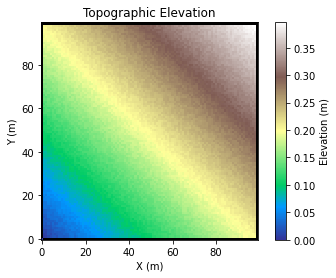

In [97]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)


In [98]:
#Parameters for SPACE and Fastscape
K_sed = 0.0001
K_sp = 0.001
K_br = 0.0001 # depends on size of spatial scale
F_f = 0.0
phi = 0.0
H_star = 1.0
v_s = 5.0
m_sp = 0.5
n_sp = 1.0
sp_crit_sed = 0
sp_crit_br = 0

#Instantiate the Flow accumulator
fr = PriorityFloodFlowRouter(mg, flow_metric='D8', suppress_out = True)

#Instantiate the Flow accumulator
fa = FlowAccumulator(mg, flow_director='D8') 

#Instantiate the depressionfinder and router as df
df = DepressionFinderAndRouter(mg,pits = 'flow__sink_flag', reroute_flow = True) 

#instantiate the fascape eroder as fsc 
fsc = FastscapeEroder(mg, K_sp, m_sp, n_sp)  

#Instantiate SPACE model with chosen parameters as sp
sp = SpaceLargeScaleEroder(mg, K_sed, K_br, F_f, phi, H_star, v_s, m_sp, n_sp, sp_crit_sed, sp_crit_br)

Run fastscape

In [99]:
#run for 10 years
t = 0
space_years = np.arange(0,100000,10000)
while t <= run_time:
    #core nodes are anything except outer boundary
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift
    #DONT ADD MG.CORE_NODES OR : AFTER TOPO ELEVATION
    #mg.at_node["topographic__elevation"][0]-= 0.001 # Uplift
    #mg.at_node["bedrock__elevation"][0]-= 0.001 # Uplift
    if x in space_years: 
        fr.run_one_step()
        sp.run_one_step(dt = timestep)
    else:
        fa.run_one_step()
        df.map_depressions()
        fsc.run_one_step(timestep)
    print(t)
    t += timestep


0
100.0
200.0
300.0
400.0
500.0
600.0
700.0
800.0
900.0
1000.0
1100.0
1200.0
1300.0
1400.0
1500.0
1600.0
1700.0
1800.0
1900.0
2000.0
2100.0
2200.0
2300.0
2400.0
2500.0
2600.0
2700.0
2800.0
2900.0
3000.0
3100.0
3200.0
3300.0
3400.0
3500.0
3600.0
3700.0
3800.0
3900.0
4000.0
4100.0
4200.0
4300.0
4400.0
4500.0
4600.0
4700.0
4800.0
4900.0
5000.0
5100.0
5200.0
5300.0
5400.0
5500.0
5600.0
5700.0
5800.0
5900.0
6000.0
6100.0
6200.0
6300.0
6400.0
6500.0
6600.0
6700.0
6800.0
6900.0
7000.0
7100.0
7200.0
7300.0
7400.0
7500.0
7600.0
7700.0
7800.0
7900.0
8000.0
8100.0
8200.0
8300.0
8400.0
8500.0
8600.0
8700.0
8800.0
8900.0
9000.0
9100.0
9200.0
9300.0
9400.0
9500.0
9600.0
9700.0
9800.0
9900.0
10000.0


Run Space

#Set elapsed time to zero
elapsed_time = 0

#Array to save sediment flux values and is currently filled with 0s
#sed_flux = [0] * int(run_time/timestep) 
#uplift_array = [0] * int(run_time/timestep)

#This will iterate through all of the years needed and will essentially run the model
while elapsed_time < run_time: #time units of years
    mg.at_node['bedrock__elevation'][mg.core_nodes] += uplift_per_timestep  #adding uplift to the bedrock
    #here you do the soil/ bedrock weathering 
    
    mg.at_node['topographic__elevation'] = mg.at_node['bedrock__elevation'] + mg.at_node['soil__depth'] #changing the elevation to account for the uplift

    fr.run_one_step()
    sp.run_one_step(dt = timestep)
    #hillslope before or after sp- orders matters on small timestep and small node spacing

    #sed_flux[count] = mg.at_node["sediment__flux"][node_next_to_outlet]
    #uplift_array[count] = uplift_rate

    elapsed_time += timestep
    print(elapsed_time)
   

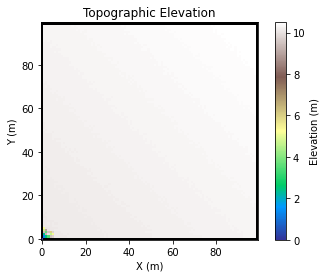

In [100]:
#Instantiate figure as empty plot
figelev = plt.figure()

#Instantiate subplot as empty plot
plot = plt.subplot()

#Create a topographic elevation plot that shows the elevation of the landscape in diff colors - using landlab utility imshow_grid
imshow_grid(mg, 'topographic__elevation', plot_name='Topographic Elevation', var_name = 'Elevation', var_units=r'm', grid_units=('m', 'm'), cmap='terrain',color_for_background=None)
